# PLOD-CW-25 Dataset Analysis

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
dataset = load_dataset('surrey-nlp/PLOD-CW-25')
print('Splits:', dataset.keys())

C:\Users\maria\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Splits: dict_keys(['train', 'test', 'validation'])


### Basic Statistics

In [2]:
for split in dataset.keys():
    print(f'{split} split: {len(dataset[split])} examples')
    print('First example:')
    print(dataset[split][0])

train split: 2000 examples
First example:
{'tokens': ['MRR', ',', 'mortality', 'rate', 'ratio', ';', 'TBI', ',', 'traumatic', 'brain', 'injury', '.'], 'pos_tags': ['NOUN', 'PUNCT', 'NOUN', 'NOUN', 'NOUN', 'PUNCT', 'PROPN', 'PUNCT', 'ADJ', 'NOUN', 'NOUN', 'PUNCT'], 'ner_tags': ['B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O', 'B-AC', 'O', 'B-LF', 'I-LF', 'I-LF', 'O']}
test split: 250 examples
First example:
{'tokens': ['Within', 'amoebae', 'and', 'macrophages', ',', 'L.', 'pneumophila', 'replicates', 'with', 'a', 'similar', 'mechanism', 'by', 'forming', 'a', 'membrane', '-', 'bound', 'compartment', ',', 'the', 'Legionella', '-', 'containing', 'vacuole', '(', 'LCV', ')', '.', 'Formation', 'of', 'the', 'LCV', 'is', 'not', 'well', 'defined', ',', 'but', 'requires', 'that', 'L.', 'pneumophila', 'injects', 'proteins', 'into', 'the', 'host', 'cell', 'via', 'the', 'intracellular', 'multiplication', '(', 'Icm)/defective', 'organelle', 'trafficking', '(', 'Dot', ')', 'secretion', 'system', '.'], 'pos_t

### Label Distribution

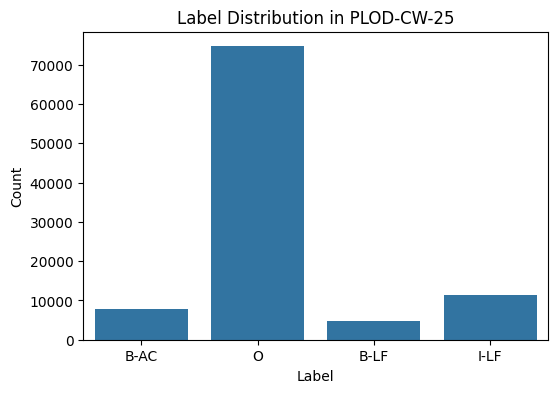

In [3]:
from collections import Counter

all_labels = []
for split in ['train', 'validation', 'test']:
    for tags in dataset[split]['ner_tags']:
        all_labels.extend(tags)
label_counts = Counter(all_labels)
plt.figure(figsize=(6,4))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Label Distribution in PLOD-CW-25')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

### Most Common Abbreviations and Long Forms

Most common abbreviations: [('-', 330), ('CI', 61), ('WT', 47), ('HR', 40), ('OR', 40), ('/', 39), ('BMI', 39), ('GFP', 39), ('TB', 31), ('SD', 28)]
Most common long forms: [('confidence interval', 34), ('wild - type', 28), ('body mass index', 28), ('green fluorescent protein', 23), ('hazard ratio', 21), ('standard deviation', 18), ('odds ratio', 16), ('knockout', 14), ('World Health Organization', 12), ('antiretroviral therapy', 12)]


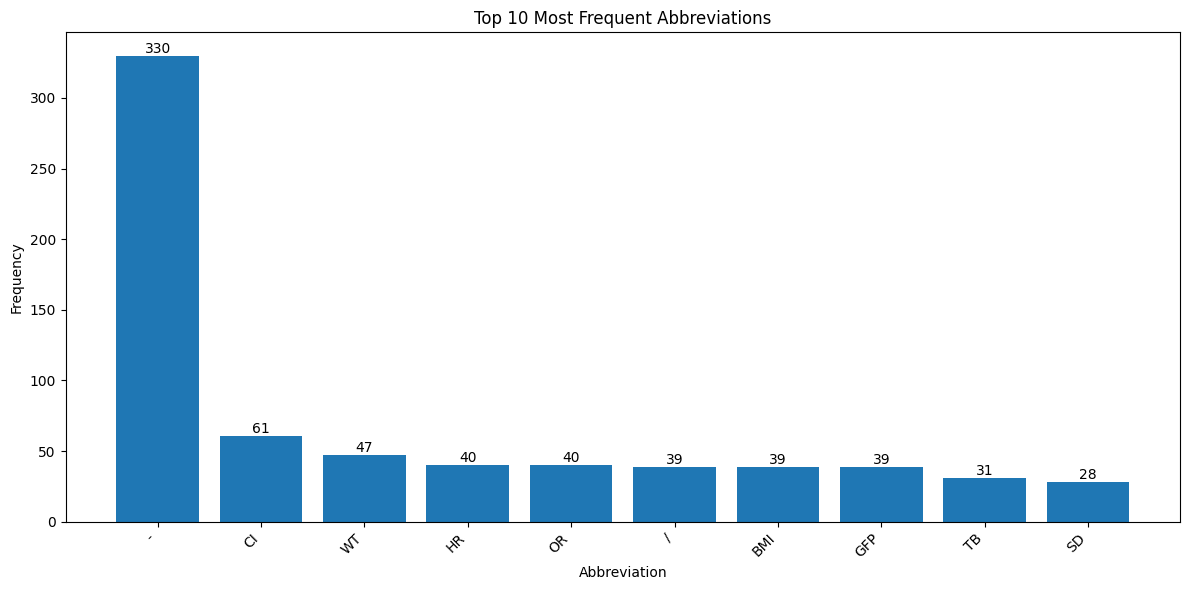

In [15]:
abbrev_counter = Counter()
longform_counter = Counter()
for tokens, tags in zip(dataset['train']['tokens'], dataset['train']['ner_tags']):
    i = 0
    while i < len(tags):
        if tags[i] == 'B-AC':
            abbrev_counter[tokens[i]] += 1
        elif tags[i] == 'B-LF':
            lf = [tokens[i]]
            j = i + 1
            while j < len(tags) and tags[j] == 'I-LF':
                lf.append(tokens[j])
                j += 1
            longform_counter[' '.join(lf)] += 1
            i = j - 1
        i += 1
print('Most common abbreviations:', abbrev_counter.most_common(10))
print('Most common long forms:', longform_counter.most_common(10))

plt.figure(figsize=(12, 6))
most_common_abbrevs = abbrev_counter.most_common(10)
abbrevs, counts = zip(*most_common_abbrevs)

# Create the bar chart
plt.bar(abbrevs, counts)
plt.title('Top 10 Most Frequent Abbreviations')
plt.xlabel('Abbreviation')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add value labels on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()


### POS Tag Distribution

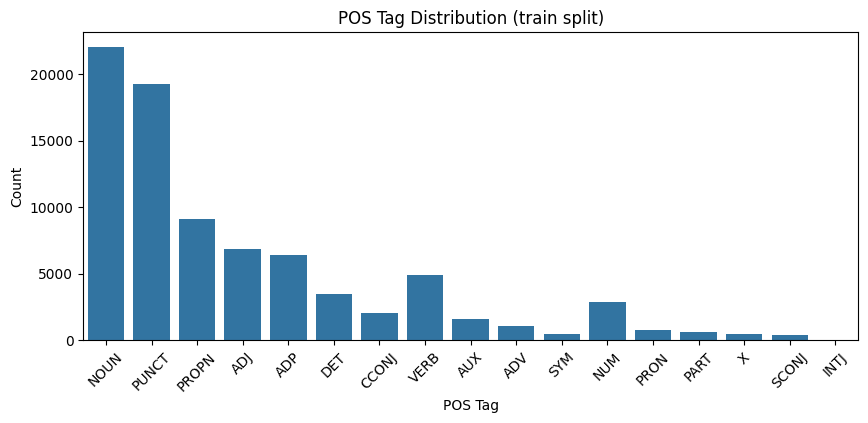

In [5]:
all_pos = []
for pos_seq in dataset['train']['pos_tags']:
    all_pos.extend(pos_seq)
pos_counts = Counter(all_pos)
plt.figure(figsize=(10,4))
sns.barplot(x=list(pos_counts.keys()), y=list(pos_counts.values()))
plt.title('POS Tag Distribution (train split)')
plt.ylabel('Count')
plt.xlabel('POS Tag')
plt.xticks(rotation=45)
plt.show()

### Domain Ananlysis

Analyzing potential sub-domains based on abbreviation patterns:


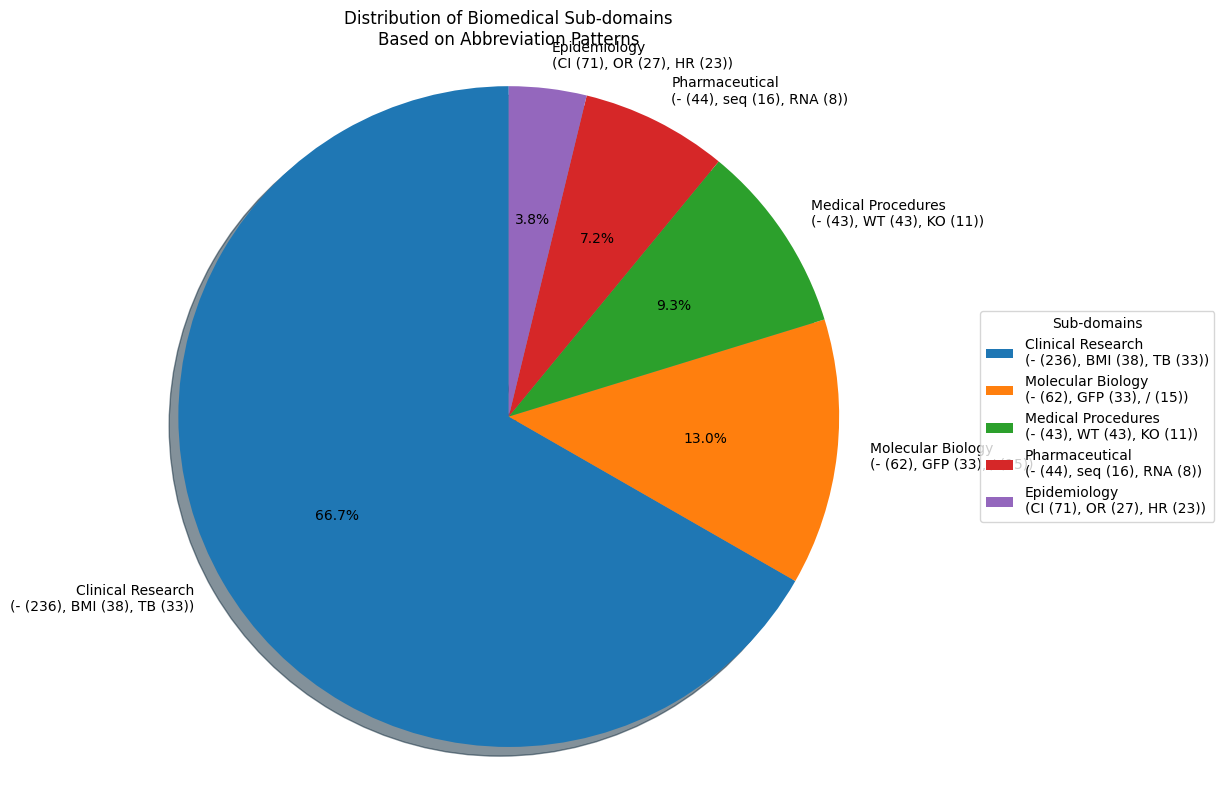

In [18]:
# Analyze potential sub-domains based on terminology clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter

def analyze_domains():
    # Combine tokens into sentences for each example
    sentences = []
    all_tokens = []  # Store all tokens and their tags
    all_tags = []
    
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            sentences.append(' '.join(tokens))
            all_tokens.append(tokens)
            all_tags.append(tags)
    
    # Create TF-IDF vectors
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(sentences)
    
    # Cluster the documents
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)
    
    # Get cluster sizes
    cluster_sizes = np.bincount(clusters)
    
    # Analyze abbreviations in each cluster
    cluster_abbrevs = {i: Counter() for i in range(n_clusters)}
    
    for i, (tokens, tags) in enumerate(zip(all_tokens, all_tags)):
        cluster = clusters[i]
        for token, tag in zip(tokens, tags):
            if tag == 'B-AC':  # If it's an abbreviation
                cluster_abbrevs[cluster][token] += 1
    
    # Create labels using domain names and top 3 abbreviations
    cluster_labels = []
    domain_names = {
        0: "Clinical Research",
        1: "Molecular Biology",
        2: "Medical Procedures",
        3: "Pharmaceutical",
        4: "Epidemiology"
    }
    
    for i in range(n_clusters):
        top_abbrevs = cluster_abbrevs[i].most_common(3)
        abbrev_str = ', '.join([f"{abbrev} ({count})" for abbrev, count in top_abbrevs])
        cluster_labels.append(f"{domain_names[i]}\n({abbrev_str})")
    
    # Create the pie chart
    plt.figure(figsize=(12, 8))
    plt.pie(cluster_sizes, labels=cluster_labels, autopct='%1.1f%%', 
            startangle=90, shadow=True)
    plt.title('Distribution of Biomedical Sub-domains\nBased on Abbreviation Patterns')
    plt.axis('equal')
    
    # Add a legend
    plt.legend(cluster_labels, title="Sub-domains", 
              loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    
    plt.tight_layout()
    plt.show()

# Run domain analysis
print("Analyzing potential sub-domains based on abbreviation patterns:")
analyze_domains()

### Length Analysis of Abbreviations and Long Forms

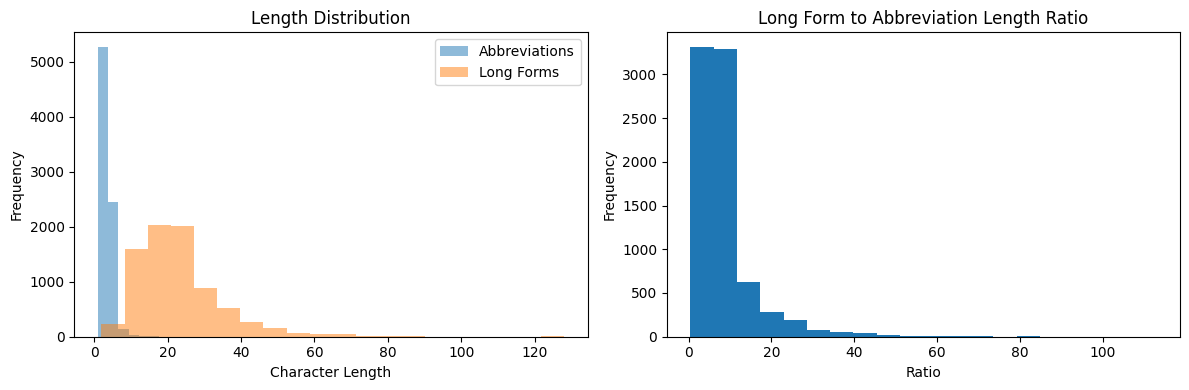

In [8]:
# Analyze lengths of abbreviations and their corresponding long forms
def analyze_lengths():
    abbrev_lengths = []
    longform_lengths = []
    ratios = []
    
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            i = 0
            while i < len(tags):
                if tags[i] == 'B-AC':
                    abbrev_len = len(tokens[i])
                    # Look for corresponding long form
                    j = 0
                    while j < len(tags):
                        if tags[j] == 'B-LF':
                            lf = []
                            k = j
                            while k < len(tags) and tags[k] in ['B-LF', 'I-LF']:
                                lf.append(tokens[k])
                                k += 1
                            lf_len = sum(len(word) for word in lf)
                            abbrev_lengths.append(abbrev_len)
                            longform_lengths.append(lf_len)
                            ratios.append(lf_len/abbrev_len)
                            break
                        j += 1
                i += 1
    
    return abbrev_lengths, longform_lengths, ratios

# Plot length distributions
abbrev_lens, longform_lens, ratios = analyze_lengths()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(abbrev_lens, bins=20, alpha=0.5, label='Abbreviations')
ax1.hist(longform_lens, bins=20, alpha=0.5, label='Long Forms')
ax1.set_title('Length Distribution')
ax1.set_xlabel('Character Length')
ax1.set_ylabel('Frequency')
ax1.legend()

ax2.hist(ratios, bins=20)
ax2.set_title('Long Form to Abbreviation Length Ratio')
ax2.set_xlabel('Ratio')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Position Analysis

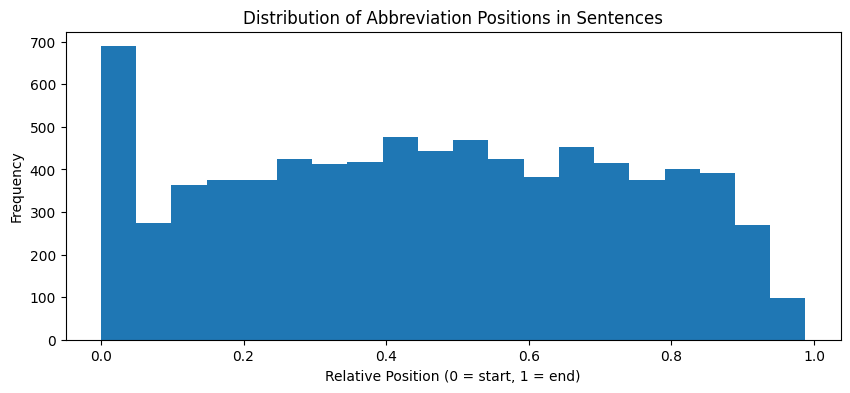

Mean position: 0.46
Median position: 0.46
Most common position range: 0.46


In [9]:
# Analyze abbreviation positions in sentences
def analyze_positions():
    positions = []
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            for i, tag in enumerate(tags):
                if tag == 'B-AC':
                    # Calculate relative position (0 to 1)
                    position = i / len(tokens)
                    positions.append(position)
    return positions

# Plot position distribution
positions = analyze_positions()
plt.figure(figsize=(10, 4))
plt.hist(positions, bins=20)
plt.title('Distribution of Abbreviation Positions in Sentences')
plt.xlabel('Relative Position (0 = start, 1 = end)')
plt.ylabel('Frequency')
plt.show()

# Print position statistics
print(f"Mean position: {np.mean(positions):.2f}")
print(f"Median position: {np.median(positions):.2f}")
print(f"Most common position range: {np.percentile(positions, 50):.2f}")

Context Analysis

Most common words before abbreviations:
[('(', 2282), (';', 1626), ('-', 467), (',', 365), ('of', 246), ('the', 200), ('and', 161), ('[', 91), ('.', 89), (':', 83)]

Most common words after abbreviations:
[(',', 2261), (')', 2132), ('-', 549), (':', 203), ('(', 181), ('and', 147), ('=', 143), ('.', 126), (']', 90), ('/', 78)]

Most common explicit definitions:
[('body weight', 1), ('intraperitoneal glucose tolerance test', 1), ('insulin tolerance test', 1), ('triglyceride', 1), ('Alanine Aminotransferase', 1), ('Maternal Postnatal Attachment Scale', 1), ('objective structured clinical examination', 1), ('rapid diagnostic tests', 1), ('C - reactive protein', 1), ('computer tomography', 1)]


C:\Users\maria\AppData\Local\Temp\ipykernel_26480\1997468355.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(words, rotation=45, ha='right')
C:\Users\maria\AppData\Local\Temp\ipykernel_26480\1997468355.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(words, rotation=45, ha='right')


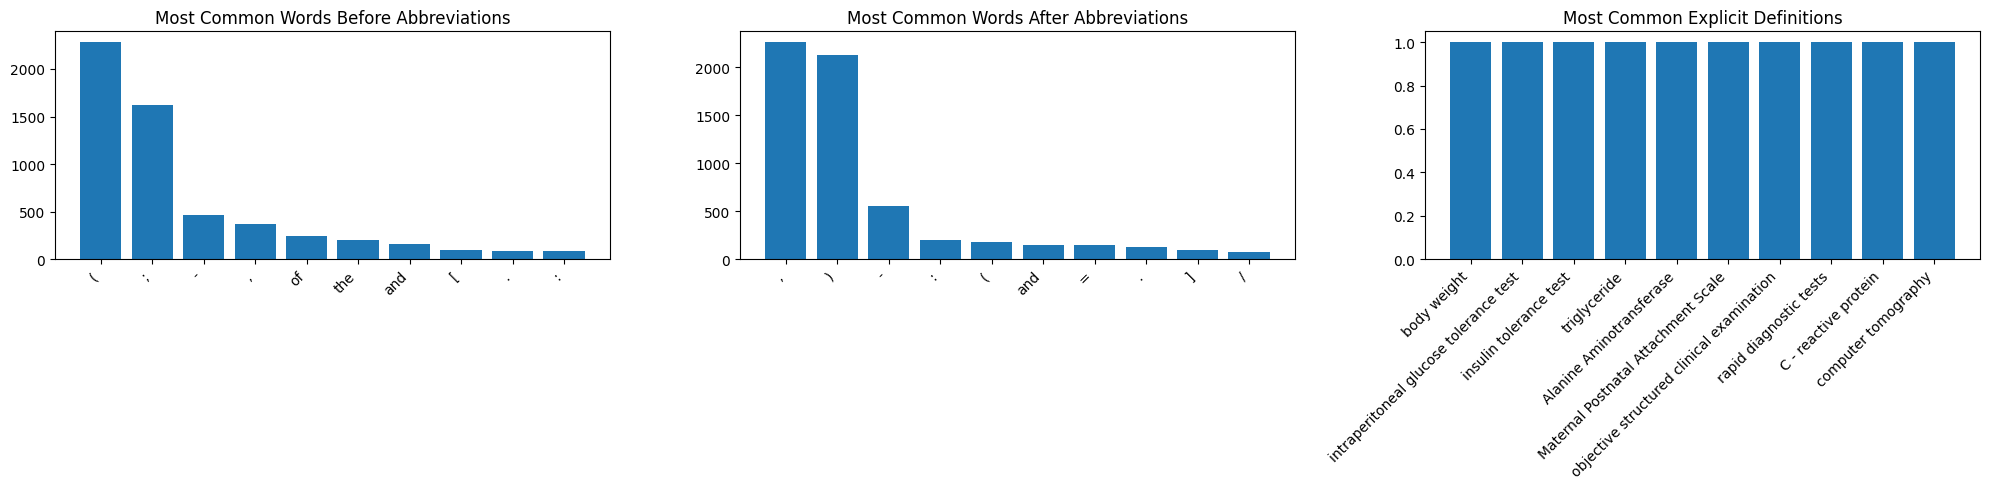


Example explicit definitions:
- body weight
- intraperitoneal glucose tolerance test
- insulin tolerance test
- triglyceride
- Alanine Aminotransferase


In [21]:
def analyze_context():
    context_words = {
        'before': [],
        'after': [],
        'explicit_def': []  # New category for explicit definitions
    }
    
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            for i, tag in enumerate(tags):
                if tag == 'B-AC':
                    # Get word before abbreviation
                    if i > 0:
                        context_words['before'].append(tokens[i-1].lower())
                    # Get word after abbreviation
                    if i < len(tokens) - 1:
                        context_words['after'].append(tokens[i+1].lower())
                    
                    # Check for explicit definition pattern
                    # Pattern 1: long form (abbreviation)
                    if i > 0 and tags[i-1] == 'B-LF':
                        lf_tokens = []
                        j = i - 1
                        while j >= 0 and tags[j] in ['B-LF', 'I-LF']:
                            lf_tokens.insert(0, tokens[j])
                            j -= 1
                        context_words['explicit_def'].append(' '.join(lf_tokens))
                    
                    # Pattern 2: abbreviation, long form
                    elif i < len(tokens) - 1 and tags[i+1] == 'B-LF':
                        lf_tokens = []
                        j = i + 1
                        while j < len(tags) and tags[j] in ['B-LF', 'I-LF']:
                            lf_tokens.append(tokens[j])
                            j += 1
                        context_words['explicit_def'].append(' '.join(lf_tokens))
    
    return context_words

# Analyze and display most common context words
context_words = analyze_context()
from collections import Counter

print("Most common words before abbreviations:")
print(Counter(context_words['before']).most_common(10))
print("\nMost common words after abbreviations:")
print(Counter(context_words['after']).most_common(10))
print("\nMost common explicit definitions:")
print(Counter(context_words['explicit_def']).most_common(10))

# Plot context word frequencies
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Before words
before_words = Counter(context_words['before']).most_common(10)
words, counts = zip(*before_words)
ax1.bar(words, counts)
ax1.set_title('Most Common Words Before Abbreviations')
ax1.set_xticklabels(words, rotation=45, ha='right')

# After words
after_words = Counter(context_words['after']).most_common(10)
words, counts = zip(*after_words)
ax2.bar(words, counts)
ax2.set_title('Most Common Words After Abbreviations')
ax2.set_xticklabels(words, rotation=45, ha='right')

# Explicit definitions
explicit_defs = Counter(context_words['explicit_def']).most_common(10)
defs, counts = zip(*explicit_defs)
ax3.bar(range(len(defs)), counts)
ax3.set_title('Most Common Explicit Definitions')
ax3.set_xticks(range(len(defs)))
ax3.set_xticklabels(defs, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Print some examples of explicit definitions
print("\nExample explicit definitions:")
for def_ in explicit_defs[:5]:
    print(f"- {def_[0]}")

Case Analysis

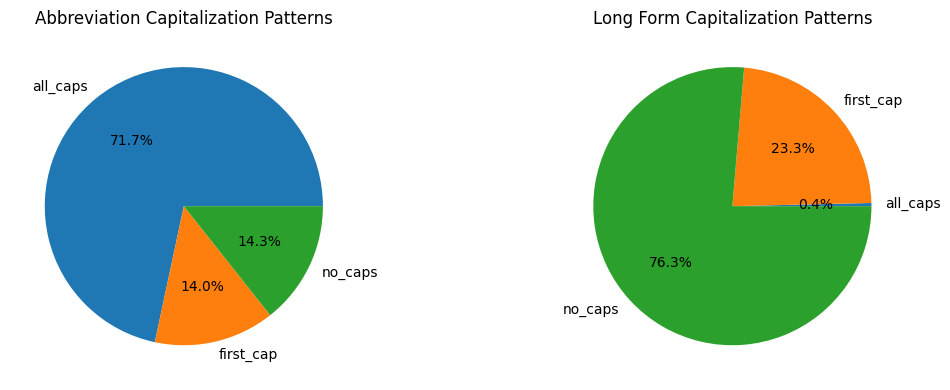

Abbreviation capitalization patterns:
all_caps: 5683
first_cap: 1111
no_caps: 1137

Long form capitalization patterns:
all_caps: 29
first_cap: 1846
no_caps: 6053


In [11]:
# Analyze capitalization patterns
def analyze_capitalization():
    abbrev_caps = {'all_caps': 0, 'first_cap': 0, 'no_caps': 0}
    longform_caps = {'all_caps': 0, 'first_cap': 0, 'no_caps': 0}
    
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            i = 0
            while i < len(tags):
                if tags[i] == 'B-AC':
                    abbrev = tokens[i]
                    # Analyze abbreviation capitalization
                    if abbrev.isupper():
                        abbrev_caps['all_caps'] += 1
                    elif abbrev[0].isupper():
                        abbrev_caps['first_cap'] += 1
                    else:
                        abbrev_caps['no_caps'] += 1
                    
                    # Look for corresponding long form
                    j = 0
                    while j < len(tags):
                        if tags[j] == 'B-LF':
                            lf = []
                            k = j
                            while k < len(tags) and tags[k] in ['B-LF', 'I-LF']:
                                lf.append(tokens[k])
                                k += 1
                            # Analyze long form capitalization
                            lf_str = ' '.join(lf)
                            if lf_str.isupper():
                                longform_caps['all_caps'] += 1
                            elif lf_str[0].isupper():
                                longform_caps['first_cap'] += 1
                            else:
                                longform_caps['no_caps'] += 1
                            break
                        j += 1
                i += 1
    
    return abbrev_caps, longform_caps

# Plot capitalization patterns
abbrev_caps, longform_caps = analyze_capitalization()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.pie(abbrev_caps.values(), labels=abbrev_caps.keys(), autopct='%1.1f%%')
ax1.set_title('Abbreviation Capitalization Patterns')

ax2.pie(longform_caps.values(), labels=longform_caps.keys(), autopct='%1.1f%%')
ax2.set_title('Long Form Capitalization Patterns')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("Abbreviation capitalization patterns:")
for pattern, count in abbrev_caps.items():
    print(f"{pattern}: {count}")
print("\nLong form capitalization patterns:")
for pattern, count in longform_caps.items():
    print(f"{pattern}: {count}")

Frequency Analysis

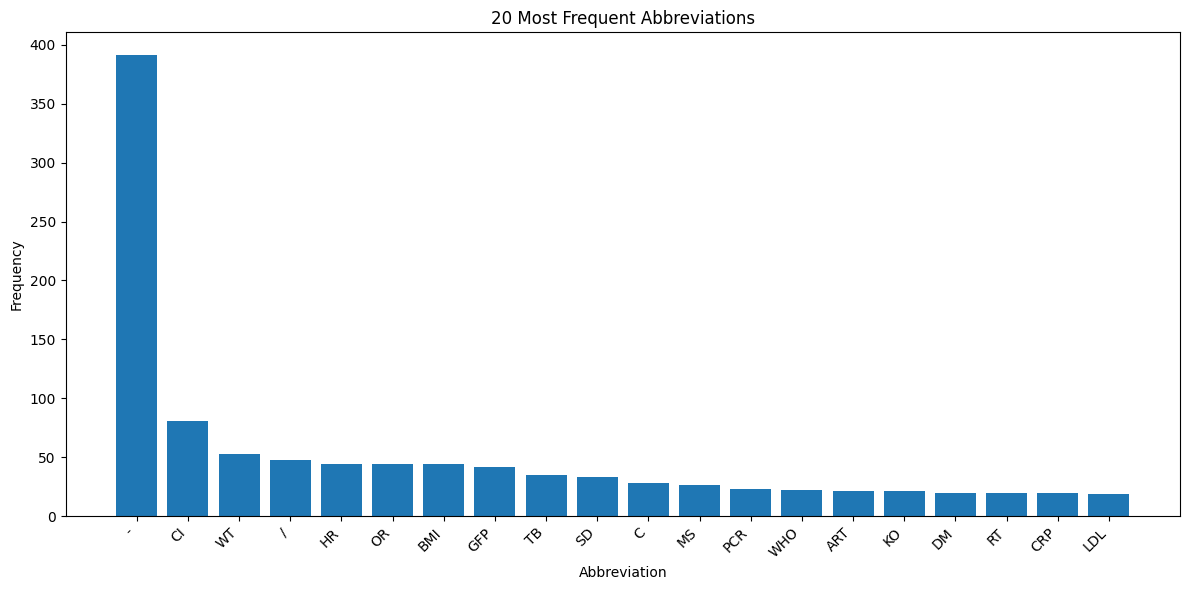

Total unique abbreviations: 3821
Most common abbreviations and their frequencies:
-: 391
CI: 81
WT: 53
/: 48
HR: 44
OR: 44
BMI: 44
GFP: 42
TB: 35
SD: 33
C: 28
MS: 26
PCR: 23
WHO: 22
ART: 21
KO: 21
DM: 20
RT: 20
CRP: 20
LDL: 19

Frequency Statistics:
Mean frequency: 2.08
Median frequency: 1.00
Standard deviation: 7.02
Min frequency: 1
Max frequency: 391


In [12]:
# Analyze abbreviation frequencies
def analyze_frequencies():
    abbrev_freq = Counter()
    for split in ['train', 'validation', 'test']:
        for tokens, tags in zip(dataset[split]['tokens'], dataset[split]['ner_tags']):
            for i, tag in enumerate(tags):
                if tag == 'B-AC':
                    abbrev_freq[tokens[i]] += 1
    return abbrev_freq

# Plot most frequent abbreviations
abbrev_freq = analyze_frequencies()
most_common = abbrev_freq.most_common(20)

plt.figure(figsize=(12, 6))
abbrevs, freqs = zip(*most_common)
plt.bar(abbrevs, freqs)
plt.xticks(rotation=45, ha='right')
plt.title('20 Most Frequent Abbreviations')
plt.xlabel('Abbreviation')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Print detailed frequency statistics
print(f"Total unique abbreviations: {len(abbrev_freq)}")
print(f"Most common abbreviations and their frequencies:")
for abbrev, freq in most_common:
    print(f"{abbrev}: {freq}")

# Calculate additional statistics
freqs = list(abbrev_freq.values())
print(f"\nFrequency Statistics:")
print(f"Mean frequency: {np.mean(freqs):.2f}")
print(f"Median frequency: {np.median(freqs):.2f}")
print(f"Standard deviation: {np.std(freqs):.2f}")
print(f"Min frequency: {min(freqs)}")
print(f"Max frequency: {max(freqs)}")